In [1]:
import IPython
import pandas as pd
from scipy.io import wavfile
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os

In [5]:
new_samplerate = 4410

# Combining into 1 CSV

In [6]:
directory = '../../data/wav_csvs/downsample'
x_files = []
y_files = []
for filename in os.listdir(directory):
    print(filename)
    if('xData' in filename and '-10.csv' in filename):
        x_files.append(pd.read_csv(directory + '/' + filename, index_col=0))
    elif('yData' in filename and '-10.csv' in filename):
        y_files.append(pd.read_csv(directory + '/' + filename, index_col=0))
    else:
        print('not added')

.DS_Store
not added
xData0-50-10.csv
xData1-50-10.csv
xData10-50-10.csv
xData11-50-10.csv
xData13-50-10.csv
xData14-50-10.csv
xData2-50-10.csv
xData3-50-10.csv
xData4-50-10.csv
xData5-50-10.csv
xData6-50-10.csv
xData7-50-10.csv
xData8-50-10.csv
xData9-50-10.csv
yData0-50-10.csv
yData1-50-10.csv
yData10-50-10.csv
yData11-50-10.csv
yData13-50-10.csv
yData14-50-10.csv
yData2-50-10.csv
yData3-50-10.csv
yData4-50-10.csv
yData5-50-10.csv
yData6-50-10.csv
yData7-50-10.csv
yData8-50-10.csv
yData9-50-10.csv


In [7]:
x_combined = pd.concat(x_files)
y_combined = pd.concat(y_files)

In [11]:
xy_combined = pd.concat([x_combined, y_combined], axis = 1)

In [12]:
xy_combined.shape

(1400, 66150)

In [16]:
temp_list = []
for x in range(0, len(xy_combined.iloc[0]), 3 * new_samplerate):
    temp_list.append(xy_combined.iloc[:,x:x + 3 * new_samplerate])
    print(temp_list[-1].shape)

(1400, 13230)
(1400, 13230)
(1400, 13230)
(1400, 13230)
(1400, 13230)


In [31]:
for x in range(5):
    temp_list[x].columns = np.arange(3 * new_samplerate)

In [33]:
xy_combined = pd.concat(temp_list, axis = 0, ignore_index = True)

## Data Sequencing

<img src="https://www.tensorflow.org/tutorials/structured_data/images/lstm_many_window.png" />

In [34]:
def split_sequence(sequence, windowsize , num_elements, num_segments):
    X_split, y_split = np.zeros(shape=(num_segments, windowsize)), np.zeros(shape=(num_segments, windowsize))
    for i in range(0, num_segments):
        # find the end of this pattern
        end_ix = i * windowsize + windowsize
        end_iy = end_ix + windowsize
        X_split[i, :] = sequence[i * windowsize : end_ix]
        y_split[i, :] = sequence[end_ix:end_iy]
    return X_split, y_split

In [35]:
# number samples for every input
windowsize = new_samplerate // 10

# number of inputs
num_segments = len(xy_combined.iloc[0]) // windowsize - 1
num_elements = len(xy_combined.iloc[0]) - 2 * windowsize

In [36]:
# initialzing the empty arrays

# (# of datapoints, # of inputs, samples per input)
x_shape = (len(xy_combined), num_segments, windowsize)
# (# of datapoints, # of inputs, samples per output)
y_shape = (len(xy_combined), num_segments, windowsize)

X = np.zeros(shape=x_shape)
y = np.zeros(shape=y_shape)

In [37]:
%%time
for index in range(len(x_combined)):
    if(index % int(len(x_combined) / 100) == 0):
        print("%.2f" % (index/len(x_combined)), " - ", index)
    X[index, :, :], y[index, :, :] = split_sequence(xy_combined.iloc[index], windowsize, num_elements, num_segments)

0.00  -  0
0.01  -  14
0.02  -  28
0.03  -  42
0.04  -  56
0.05  -  70
0.06  -  84
0.07  -  98
0.08  -  112
0.09  -  126
0.10  -  140
0.11  -  154
0.12  -  168
0.13  -  182
0.14  -  196
0.15  -  210
0.16  -  224
0.17  -  238
0.18  -  252
0.19  -  266
0.20  -  280
0.21  -  294
0.22  -  308
0.23  -  322
0.24  -  336
0.25  -  350
0.26  -  364
0.27  -  378
0.28  -  392
0.29  -  406
0.30  -  420
0.31  -  434
0.32  -  448
0.33  -  462
0.34  -  476
0.35  -  490
0.36  -  504
0.37  -  518
0.38  -  532
0.39  -  546
0.40  -  560
0.41  -  574
0.42  -  588
0.43  -  602
0.44  -  616
0.45  -  630
0.46  -  644
0.47  -  658
0.48  -  672
0.49  -  686
0.50  -  700
0.51  -  714
0.52  -  728
0.53  -  742
0.54  -  756
0.55  -  770
0.56  -  784
0.57  -  798
0.58  -  812
0.59  -  826
0.60  -  840
0.61  -  854
0.62  -  868
0.63  -  882
0.64  -  896
0.65  -  910
0.66  -  924
0.67  -  938
0.68  -  952
0.69  -  966
0.70  -  980
0.71  -  994
0.72  -  1008
0.73  -  1022
0.74  -  1036
0.75  -  1050
0.76  -  1064
0.7

In [38]:
train_size = int(0.8 * len(X))

X_train = X[:train_size,:,:]
y_train = y[:train_size,:,:]

X_test = X[train_size:,:,:]
y_test = y[train_size:,:,:]

In [39]:
X_train.shape

(5600, 29, 441)

## Creating the Model

In [207]:
# https://gitlab.com/michael-lewis/wav-nn/-/blob/master/wav-nn.ipynb
def create_model(input_dim, output_dim):
#     model.add(LSTM(
#         256,
#         input_shape=(network_input.shape[1], network_input.shape[2]),
#         return_sequences=True
#     ))
#     model.add(Dropout(0.3))
#     model.add(LSTM(512, return_sequences=True))
#     model.add(Dropout(0.3))
#     model.add(LSTM(256))
#     model.add(Dense(256))
#     model.add(Dropout(0.3))
#     model.add(Dense(n_vocab))
#     model.add(Activation('softmax'))
    model = keras.Sequential()
    # Add an Embedding layer expecting input vocab of size 1000, and
    # output embedding dimension of size 64.
#     model.add(layers.Embedding(input_dim=input_dim, output_dim=64))

#     # Add a LSTM layer with 128 internal units.
#     model.add(tf.keras.layers.Conv1D(filters=32, kernel_size=5,
#             strides=1, padding="causal", activation="relu", input_shape=input_dim[1:]))

    
    
    # https://www.tensorflow.org/tutorials/structured_data/time_series
    
    # Shape [batch, time, features] => [batch, time, lstm_units]
    model.add(layers.LSTM(256, return_sequences = True, activation = 'softmax'))
    model.add(layers.Dropout(0.3))
    model.add(layers.LSTM(512, return_sequences=True))
#     model.add(layers.Dropout(0.3))
#     model.add(layers.LSTM(256))
#     model.add(layers.Dense(256))
    
    # Shape => [batch, time, features]
    model.add(layers.Dense(output_dim[2]))
    
    return model

In [208]:
model = create_model(X_train.shape, y_train.shape)

In [215]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(lr=0.1),
    loss=tf.keras.losses.MSE
)

trace = model.fit(x=X_train[:,:,:], 
                  y=y_train[0:30,:,:], 
                  batch_size=16, epochs=40, verbose=1, 
                  validation_split=0.1, shuffle=True)

Epoch 1/40
2/2 [==============================] - 1s 743ms/step - loss: 64683836.0000 - val_loss: 32225154.0000
Epoch 2/40
2/2 [==============================] - 1s 366ms/step - loss: 64734648.0000 - val_loss: 32247590.0000
Epoch 3/40
2/2 [==============================] - 1s 296ms/step - loss: 64681284.0000 - val_loss: 32253902.0000
Epoch 4/40
2/2 [==============================] - 1s 354ms/step - loss: 64678192.0000 - val_loss: 32254570.0000
Epoch 5/40
2/2 [==============================] - 1s 412ms/step - loss: 64676060.0000 - val_loss: 32257906.0000
Epoch 6/40
2/2 [==============================] - 1s 294ms/step - loss: 64674004.0000 - val_loss: 32266688.0000
Epoch 7/40
2/2 [==============================] - 1s 301ms/step - loss: 64667256.0000 - val_loss: 32274926.0000
Epoch 8/40
2/2 [==============================] - 1s 293ms/step - loss: 64662352.0000 - val_loss: 32283178.0000
Epoch 9/40
2/2 [==============================] - 1s 312ms/step - loss: 64660196.0000 - val_loss: 322911

In [216]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_17 (LSTM)               (None, 29, 256)           714752    
_________________________________________________________________
dropout_2 (Dropout)          (None, 29, 256)           0         
_________________________________________________________________
lstm_18 (LSTM)               (None, 29, 512)           1574912   
_________________________________________________________________
dense_11 (Dense)             (None, 29, 441)           226233    
Total params: 2,515,897
Trainable params: 2,515,897
Non-trainable params: 0
_________________________________________________________________


## Visualizing Results

In [217]:
def get_audio(true_val, pred_val, index_num = 0, perc_song = 1):
    true_val = true_val[index_num, :, :].flatten()
    pred_val = pred_val[index_num, :, :].flatten()
    
    return true_val, pred_val

In [218]:
def plot_data(true_val, pred_val, index_num = 0, num_seconds = 3, start = 0):
    
    desired_length = int(num_seconds * new_samplerate)
    
    beginning = int(start * new_samplerate)
    
    x = np.arange(beginning, beginning + desired_length)/new_samplerate
    true_val = true_val[index_num, :, :].flatten()[beginning:]
    pred_val = pred_val[index_num, :, :].flatten()[beginning + windowsize:]
    
    
    plt.figure(figsize=(15,5))
    plt.plot(x, true_val[:desired_length], label='true')
    plt.plot(x, pred_val[:desired_length], label='pred')
    
    min_val = min(np.min(true_val), np.min(pred_val))
    max_val = max(np.max(true_val), np.max(pred_val))
    
    start_index = ((start * new_samplerate + 1) // windowsize) * windowsize
    plt.vlines(np.arange(start_index, start_index + desired_length, windowsize) / new_samplerate, 
                            ymin = min_val, ymax = max_val, colors='y')
    plt.legend()

    plt.show
    return pred_val

In [219]:
y_pred = model.predict(X_train)

array([-204.3748  ,  -86.672165,  155.11952 , ..., -515.43787 ,
       -464.9161  , -351.63092 ], dtype=float32)

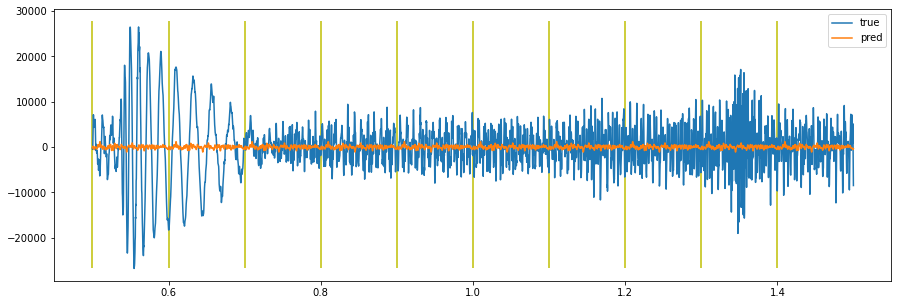

In [220]:
plot_data(X_train, y_pred, 1, 1, 0.5)

In [120]:
IPython.display.Audio(data = get_audio(X_train, y_pred, 1, 1)[1], rate = new_samplerate)

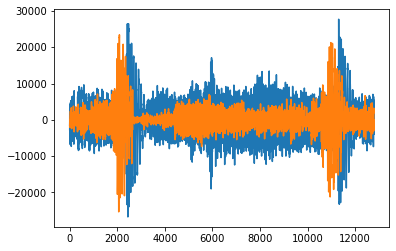

In [122]:
a, b = get_audio(X_train, y_pred, 1, 1)
plt.plot(np.arange(len(a)), a)
plt.plot(np.arange(len(b)), b)
plt.show()